# State Student Spending Case Study
#### Examining any relationship between student sucess or lack thereof with how much money the state has invested.
Using each state's dropout rate as a benchmark of student success. We will investigate any correlations.


### Necessary Steps for Data Story
##### 1) Clean the Data 
    a. Import Data
    b. Transform variables
##### 2) Merge the Data
##### 3) Exploratory Data Analysis
    a. Visualize the data
##### 4) Preprocess and Train Data
##### 5) Create Machine Learning Model
##### 6) Summarize Findings

In [1]:
#import necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
from plotnine import *

# 1. Import Data

In [2]:
#import Graduation rate, Dropout rate, State Spending, Population, & State GDP data
Grad = pd.read_csv('Data/Completion1118.csv')
Drop = pd.read_csv('Data/Dropout1018Final.csv')
StateSpend = pd.read_excel('Data/StateSpendingStudents.xlsx')
Pop = pd.read_csv('Data/Pop10-19.csv')
GDP = pd.read_csv('Data/State Quarterly GDP 2005 - 2021 - Sheet1.csv')

In [3]:
#import tax data 
Tax11 = pd.read_csv('Data/2011 State Taxes.csv').replace('X', 0)
Tax12 = pd.read_csv('Data/2012 State Taxes.csv').replace('X', 0)
Tax13 = pd.read_csv('Data/2013 State Taxes.csv').replace('X', 0)
Tax14 = pd.read_csv('Data/2014 State Taxes.csv').replace('X', 0)
Tax15 = pd.read_csv('Data/2015 State Taxes.csv').replace('X', 0)
Tax16 = pd.read_csv('Data/2016 State Taxes.csv').replace('X', 0)
Tax17 = pd.read_csv('Data/2017 State Taxes.csv').replace('X', 0)
Tax18 = pd.read_csv('Data/2018 State Taxes.csv').replace('X', 0)
Tax19 = pd.read_csv('Data/2019 State Taxes.csv').replace('X', 0)


#Note to self to automate process:
#Try a dictionary. Start with empty dictionary. Wild cards to read itieratively * .csv

## Cleaning Tax Data

In [4]:
#Examing the column names: Need to change them to match the rest of the data
#Tax13.columns

In [5]:
#Dictionary to change state abbreviations to full state names
us_state_abbrev = {
    'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona',
    'AR': 'Arkansas','CA': 'California','CO': 'Colorado',
    'CT': 'Connecticut','DE': 'Delaware','FL': 'Florida',
    'GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho',
    'IL': 'Illinois','IN': 'Indiana','IA': 'Iowa',
    'KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
    'ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts',
    'MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi',
    'MO': 'Missouri','MT': 'Montana','NE': 'Nebraska',
    'NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey',
    'NM': 'New Mexico','NY': 'New York','NC': 'North Carolina',
    'ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
    'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island',
    'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee',
    'TX': 'Texas','UT': 'Utah','VT': 'Vermont',
    'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia',
    'WI': 'Wisconsin','WY': 'Wyoming','District of Columbia': 'DC',
}

In [6]:
#Load all the individual tax files into one frame with an appropriate year varibable

TaxList = [Tax11, Tax12, Tax13, Tax14, Tax15, Tax16, Tax17, Tax18, Tax19]

TaxFile = pd.DataFrame()


initial_year = 2011
for loc_file in TaxList:
  loc_file = loc_file.iloc[:,1:]
  loc_file['Year'] = str(initial_year)
  loc_file = loc_file.melt(id_vars='Year', value_name = 'TaxAll', var_name='State')
  TaxFile  = TaxFile.append(loc_file)
  initial_year = initial_year + 1

In [7]:
#Sum all the different types of tax categories
TaxFile['TaxAll'] = TaxFile['TaxAll'].astype('float')

AllTaxes = TaxFile.groupby(['State', 'Year'])['TaxAll'].sum().reset_index()
AllTaxes.head()

,State,Year,TaxAll
0,AK,2011,5537679.0
1,AK,2012,7049398.0
2,AK,2013,5132811.0
3,AK,2014,3392870.0
4,AK,2015,1363350.0


In [8]:
#Fix the naming
AllTaxes['State'] = AllTaxes['State'].replace(us_state_abbrev)
AllTaxes.head()

,State,Year,TaxAll
0,Alaska,2011,5537679.0
1,Alaska,2012,7049398.0
2,Alaska,2013,5132811.0
3,Alaska,2014,3392870.0
4,Alaska,2015,1363350.0


## Cleaning Median Income Data

In [9]:
#Read in Median Income 
#(Deleted out Standard Deviation as well as repetitive information from original file)
MedianInc = pd.read_csv('Data/Median Income.csv')

#Flip
MedianInc = MedianInc.melt(id_vars = 'State', var_name='Year', value_name = 'MedInc')

MedianInc.head()

,State,Year,MedInc
0,United States,2018,"63,179"
1,Alabama,2018,"49,936"
2,Alaska,2018,"68,734"
3,Arizona,2018,"62,283"
4,Arkansas,2018,"49,781"


In [10]:
#Remove commas from integers so we can explore numerical calculations

for x in range(len(MedianInc)):
    MedianInc['MedInc'][x] = MedianInc['MedInc'][x].replace(',' , '')

In [11]:
MedianInc.tail()

,State,Year,MedInc
1815,Virginia,1984,26525
1816,Washington,1984,25017
1817,West Virginia,1984,16843
1818,Wisconsin,1984,20743
1819,Wyoming,1984,23816


## Cleaning Graduation and Drop Out Data

In [12]:
#Examine data
print(Grad.columns)

Index(['State', '2010-11', '2011-12', '2012-13', '2013- 14', '2014- 15',
       '2015- 16', '2016- 17', '2017-18'],
      dtype='object')


In [13]:
#Rename columns so they match years in other files.
oldname = Grad.columns
newname = ['State', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018 ]
Grad = Grad.rename(columns=dict(zip(oldname, newname)))

#Flip so States are columns
Grad = Grad.melt(id_vars = ['State'], var_name='Year', value_name = 'GraduationRate')


#Examine
Grad.head()

,State,Year,GraduationRate
0,Alabama,2011,72.0
1,Alaska,2011,68.0
2,Arizona,2011,78.0
3,Arkansas,2011,81.0
4,California,2011,76.0


In [14]:
#Examine data
print(Drop.head())
print(Drop.columns)

           State  2010  2011  2012  2013  2014  2015  2016  2017  2018
0  United States   8.3   7.7   7.0   6.8   6.3   6.0   5.8   5.4   5.3
1        Alabama  10.9  10.1   9.2   8.9   7.7   7.4   6.9   6.6   5.4
2         Alaska   7.6   7.0   6.4   6.2   2.8   8.8   5.6   5.3   4.4
3        Arizona  11.5  10.6   9.7   9.4   8.5   9.2   7.6   8.0   7.7
4       Arkansas   8.3   7.7   7.0   6.8   6.8   6.7   7.2   5.7   5.6
Index(['State', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'],
      dtype='object')


In [15]:
#Flip so States are columns
Drop = Drop.melt(id_vars = ['State'], var_name='Year', value_name = 'DropoutRate')

#Examine
Drop.head()

,State,Year,DropoutRate
0,United States,2010,8.3
1,Alabama,2010,10.9
2,Alaska,2010,7.6
3,Arizona,2010,11.5
4,Arkansas,2010,8.3


## Clean State Spending Data

In [16]:
#StateSpend.head() to examine data before cleaning

In [17]:
#Realign with States as columns & make sure the column names match the other data files.
StateSpend.rename(columns = {'state': 'State'}, inplace = True)
StateSpend = StateSpend.melt(id_vars = ['State'], var_name='Year', value_name = 'StateSpend')
StateSpend.head()

#Examine
print(StateSpend.head())

        State  Year  StateSpend
0     Alabama  1997   3271969.0
1      Alaska  1997   1042311.0
2     Arizona  1997   3388165.0
3    Arkansas  1997   1960613.0
4  California  1997  28708364.0


## Clean Population Data

In [18]:
#Examine the Population
# print(Pop.head())

In [19]:
#Fix geographic area names & delete unnecessary strings

Pop = Pop.drop(columns = ['Census', 'Estimates Base']).iloc[:58,]
Pop['Geographic Area'] = Pop['Geographic Area'].str.replace('.','')


# Combine and examine
Pop = Pop.melt(id_vars = 'Geographic Area',var_name='Year',value_name = 'Population')
Pop.tail()

,Geographic Area,Year,Population
555,Virginia,2019,"8,535,519"
556,Washington,2019,"7,614,893"
557,West Virginia,2019,"1,792,147"
558,Wisconsin,2019,"5,822,434"
559,Wyoming,2019,"578,759"


In [20]:
#Change column name to match other datasets
Pop = Pop.rename(columns={'Geographic Area' : 'State'})
Pop.head()

,State,Year,Population
0,United States,2010,"309,321,666"
1,Northeast,2010,"55,380,134"
2,Midwest,2010,"66,974,416"
3,South,2010,"114,866,680"
4,West,2010,"72,100,436"


In [21]:
Pop['Population'] = Pop['Population'].replace(" ' '", '')
Pop.head()

,State,Year,Population
0,United States,2010,"309,321,666"
1,Northeast,2010,"55,380,134"
2,Midwest,2010,"66,974,416"
3,South,2010,"114,866,680"
4,West,2010,"72,100,436"


In [22]:
#Remove commas from integers for ease of numerical computations
for x in range(len(Pop)):
    Pop['Population'][x] = Pop['Population'][x].replace(',' , '')

In [23]:
Pop.head()

,State,Year,Population
0,United States,2010,309321666
1,Northeast,2010,55380134
2,Midwest,2010,66974416
3,South,2010,114866680
4,West,2010,72100436


## Clean GDP  Data

In [24]:
#Examine GDP data before edits
# GDP.head()

In [25]:
# In order to average the GDP by year we need to extract the year
GDP['Year'] = GDP['DATE'].str[:4]
GDP.drop(columns = 'DATE', inplace = True)
GDP.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Year
0,153077.8,37393.9,219879.5,87648.2,1071327.2,215960.0,205563.8,50938.8,84367.6,679535.2,...,224177.7,959728.9,90791.3,23305.0,351558.7,289799.4,51590.1,222355.1,25403.1,2005
1,155409.9,38641.2,225374.3,88484.4,1147944.3,218742.0,207535.4,49992.1,85216.8,688958.5,...,225712.9,966652.1,92408.8,23288.1,358082.4,294263.7,52859.3,224122.0,26571.8,2005
2,156809.7,40259.9,232290.1,89890.7,1247734.4,222965.7,208749.0,50351.7,85499.3,708198.9,...,229952.8,993026.3,95362.0,23560.3,365491.2,295654.5,53610.3,228348.1,27453.0,2005
3,160315.8,42859.7,235386.5,92549.3,1366166.5,223561.9,212795.6,56830.1,86313.2,712347.7,...,232661.9,1025403.5,98650.0,23850.2,368236.9,303717.2,55111.1,227537.6,29448.8,2005
4,161732.8,42664.7,242418.5,92836.0,1387551.8,228594.0,221184.4,54220.3,87757.7,732154.4,...,236210.0,1054437.0,102069.5,24289.8,375995.3,310466.5,55639.7,232585.7,30455.1,2006


In [26]:
#Melt it down 
GDP = GDP.melt(id_vars = ['Year'], var_name='State', value_name = 'GDP')
GDP.head()

,Year,State,GDP
0,2005,Alabama,153077.8
1,2005,Alabama,155409.9
2,2005,Alabama,156809.7
3,2005,Alabama,160315.8
4,2006,Alabama,161732.8


In [27]:
#Find the average yearly GDP
YearlyGDP = GDP.groupby(['State', 'Year'])['GDP'].mean().reset_index()

In [28]:
YearlyGDP.head()

,State,Year,GDP
0,Alabama,2005,156403.30
1,Alabama,2006,164347.85
2,Alabama,2007,170263.85
3,Alabama,2008,172677.25
4,Alabama,2009,169128.50


## Clean Unemployment Rates

In [29]:
# Empty data frame
Unemployment = pd.DataFrame()


for i in np.arange(2009,2018,1):
    print("Reading: {}".format(str(i)))
    
    year_data = pd.read_excel('Data/UnemploymentRateData_Parsed.xlsx', sheet_name = str(i))
    melt_data = pd.melt(year_data, id_vars = 'State', var_name = ['Month'], value_name = 'value')

    aggregated_data = melt_data.groupby('State').agg({'value' : ['min', 'max', 'mean']}).reset_index()
    aggregated_data.columns = ['State', 'min_unemploymentRate', 'max_unemploymentRate', 'mean_unemploymentRate']
    aggregated_data['Year'] = str(i)
    
    # Logic to add each years data to the end of previously created data
    Unemployment = Unemployment.append(aggregated_data)

Unemployment.head()

Reading: 2009
Reading: 2010
Reading: 2011
Reading: 2012
Reading: 2013
Reading: 2014
Reading: 2015
Reading: 2016
Reading: 2017


,State,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,Year
0,Alabama,7.8,11.0,9.816667,2009
1,Alaska,7.9,8.9,8.383333,2009
2,Arizona,7.0,9.3,8.458333,2009
3,Arkansas,6.4,7.7,7.041667,2009
4,California,10.1,12.5,11.616667,2009


# 2. Merge the Clean Files

In [30]:
Grad['Year'] = Grad['Year'].astype('str')
Grad['State'] = Grad['State'].astype('str')

Drop['Year'] = Drop['Year'].astype('str')
Drop['State'] = Drop['State'].astype('str')

StateSpend['Year'] = StateSpend['Year'].astype('str')
StateSpend['State'] = StateSpend['State'].astype('str')

#Pop['Population'] = Pop['Population'].astype('Float64')

MedianInc['Year'] = MedianInc['Year'].astype('str')
MedianInc['State'] = MedianInc['State'].astype('str')
#MedianInc['MedInc'] = MedianInc['MedInc'].astype('Float64')

In [31]:
#merge graduate and drop data
all_merge = Grad.merge(Drop, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate
0,Alabama,2011,72.0,10.1
1,Alaska,2011,68.0,7.0
2,Arizona,2011,78.0,10.6
3,Arkansas,2011,81.0,7.7
4,California,2011,76.0,7.7


In [32]:
#Merge state spending data
all_merge = all_merge.merge(StateSpend, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend
0,Alabama,2011,72.0,10.1,6592386.0
1,Alaska,2011,68.0,7.0,2196942.0
2,Arizona,2011,78.0,10.6,7096432.0
3,Arkansas,2011,81.0,7.7,4609186.0
4,California,2011,76.0,7.7,55999628.0


In [33]:
# Merge in population
all_merge = all_merge.merge(Pop, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population
0,Alabama,2011,72.0,10.1,6592386.0,4799069
1,Alaska,2011,68.0,7.0,2196942.0,722128
2,Arizona,2011,78.0,10.6,7096432.0,6472643
3,Arkansas,2011,81.0,7.7,4609186.0,2940667
4,California,2011,76.0,7.7,55999628.0,37638369


In [34]:
#Merge in Taxes
all_merge = all_merge.merge(AllTaxes, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll
0,Alabama,2011,72.0,10.1,6592386.0,4799069,8631984.0
1,Alaska,2011,68.0,7.0,2196942.0,722128,5537679.0
2,Arizona,2011,78.0,10.6,7096432.0,6472643,12265219.0
3,Arkansas,2011,81.0,7.7,4609186.0,2940667,7952824.0
4,California,2011,76.0,7.7,55999628.0,37638369,119164086.0


In [35]:
#Merge in Median Income
all_merge = all_merge.merge(MedianInc, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc
0,Alabama,2011,72.0,10.1,6592386.0,4799069,8631984.0,42590
1,Alaska,2011,68.0,7.0,2196942.0,722128,5537679.0,57431
2,Arizona,2011,78.0,10.6,7096432.0,6472643,12265219.0,48621
3,Arkansas,2011,81.0,7.7,4609186.0,2940667,7952824.0,41302
4,California,2011,76.0,7.7,55999628.0,37638369,119164086.0,53367


In [36]:
#Merge in GDP
all_merge = all_merge.merge(YearlyGDP, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP
0,Alabama,2011,72.0,10.1,6592386.0,4799069,8631984.0,42590,181929.875
1,Alaska,2011,68.0,7.0,2196942.0,722128,5537679.0,57431,56333.925
2,Arizona,2011,78.0,10.6,7096432.0,6472643,12265219.0,48621,257881.150
3,Arkansas,2011,81.0,7.7,4609186.0,2940667,7952824.0,41302,105107.800
4,California,2011,76.0,7.7,55999628.0,37638369,119164086.0,53367,2063827.500


In [37]:
#Merge in Unemployment
all_merge = all_merge.merge(Unemployment, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
0,Alabama,2011,72.0,10.1,6592386.0,4799069,8631984.0,42590,181929.875,8.1,10.0,9.366667
1,Alaska,2011,68.0,7.0,2196942.0,722128,5537679.0,57431,56333.925,7.3,7.7,7.491667
2,Arizona,2011,78.0,10.6,7096432.0,6472643,12265219.0,48621,257881.150,8.7,9.6,9.216667
3,Arkansas,2011,81.0,7.7,4609186.0,2940667,7952824.0,41302,105107.800,7.7,8.3,7.975000
4,California,2011,76.0,7.7,55999628.0,37638369,119164086.0,53367,2063827.500,11.1,12.4,11.841667


In [39]:
all_merge['Year'] = all_merge['Year'].astype('int64') 
all_merge['DropoutRate'] = all_merge['DropoutRate'].astype('float64') 
all_merge['Population'] = all_merge['Population'].astype('float64') 
all_merge['MedInc'] = all_merge['MedInc'].astype('float64') 
all_merge.dtypes

State                     object
Year                       int64
GraduationRate           float64
DropoutRate              float64
StateSpend               float64
Population               float64
TaxAll                   float64
MedInc                   float64
GDP                      float64
min_unemploymentRate     float64
max_unemploymentRate     float64
mean_unemploymentRate    float64
dtype: object

## Clean and narrow entire data frame for research
The primary focus of this study will be on years 2011 - 2016.
Some datasets have more years, but all datasets have this range.

In [40]:
all_merge.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
0,Alabama,2011,72.0,10.1,6592386.0,4799069.0,8631984.0,42590.0,181929.875,8.1,10.0,9.366667
1,Alaska,2011,68.0,7.0,2196942.0,722128.0,5537679.0,57431.0,56333.925,7.3,7.7,7.491667
2,Arizona,2011,78.0,10.6,7096432.0,6472643.0,12265219.0,48621.0,257881.150,8.7,9.6,9.216667
3,Arkansas,2011,81.0,7.7,4609186.0,2940667.0,7952824.0,41302.0,105107.800,7.7,8.3,7.975000
4,California,2011,76.0,7.7,55999628.0,37638369.0,119164086.0,53367.0,2063827.500,11.1,12.4,11.841667


In [41]:
#Focus on keyYears greater than 2013
#All merge shows us the first year is already 2011 becaues of our left merge

#We just need to remove years greater than 2016
keyYears = all_merge[all_merge['Year'] <= 2016]

In [42]:
#Remove Washington DC & United States
keyYears = keyYears[keyYears['State'] != 'District of Columbia']
keyYears = keyYears[keyYears['State'] != 'United States']

In [43]:
print('The Number of State Identifiers:', keyYears.State.nunique())
print('As follows:', keyYears.State.unique())


The Number of State Identifiers: 50
As follows: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [44]:
print('The Number of Years Examined :', keyYears.Year.nunique())
print('As follows:', keyYears.Year.unique())

The Number of Years Examined : 6
As follows: [2011 2012 2013 2014 2015 2016]


In [45]:
#Examine for missing data
print(keyYears.isnull().sum())

State                    0
Year                     0
GraduationRate           7
DropoutRate              0
StateSpend               0
Population               0
TaxAll                   2
MedInc                   0
GDP                      0
min_unemploymentRate     0
max_unemploymentRate     0
mean_unemploymentRate    0
dtype: int64


In [47]:
keyYears[keyYears.TaxAll.isnull()]

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
217,Illinois,2015,86.0,5.1,23713992.0,12858913.0,NaN,60413.0,795326.125,5.4,6.1,5.816667
219,Iowa,2015,91.0,4.6,5381831.0,3120960.0,NaN,60855.0,179459.200,3.4,4.2,3.750000


In [48]:
#The source of the data (https://www.census.gov/data/datasets/2015/econ/stc/2015-annual.html)
#Did not have Illinois and Iowa so we will add the average of their taxes in prior years

keyYears.loc[(keyYears['State'] == 'Illinois') & (keyYears['TaxAll'].isnull()), 'TaxAll'] = keyYears[keyYears['State'] == 'Illinois']['TaxAll'].mean()
keyYears.loc[(keyYears['State'] == 'Iowa') & (keyYears['TaxAll'].isnull()), 'TaxAll'] = keyYears[keyYears['State'] == 'Iowa']['TaxAll'].mean()

In [50]:
keyYears[keyYears.GraduationRate.isnull()]

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
12,Idaho,2011,NaN,8.2,1778035.0,1583910.0,3261722.0,47459.0,56516.400,8.4,9.7,9.233333
17,Kentucky,2011,NaN,8.6,5896353.0,4369821.0,10198800.0,39856.0,170004.725,9.1,10.4,9.766667
36,Oklahoma,2011,NaN,10.0,4619381.0,3788379.0,7776210.0,48455.0,165091.375,5.3,6.6,5.891667
63,Idaho,2012,NaN,7.4,1744392.0,1595324.0,3374291.0,47922.0,57780.100,6.6,8.1,7.466667
68,Kentucky,2012,NaN,7.8,6022356.0,4386346.0,10619106.0,41086.0,176323.125,8.1,8.8,8.391667
87,Oklahoma,2012,NaN,9.1,4709798.0,3818814.0,8823958.0,48407.0,173238.800,4.7,6.1,5.233333
114,Idaho,2013,NaN,7.2,1814272.0,1611206.0,3578068.0,48467.0,61155.175,5.7,6.8,6.341667


In [51]:
#The source of the data did not have these years
# https://nces.ed.gov/programs/digest/d19/tables/dt19_219.46.asp
#Did not have 3 states in 3 different years. 
# We will add the average of their graduation rates in prior/later years

keyYears.loc[(keyYears['State'] == 'Idaho') & (keyYears['GraduationRate'].isnull()), 'GraduationRate'] = keyYears[keyYears['State'] == 'Idaho']['GraduationRate'].mean()
keyYears.loc[(keyYears['State'] == 'Kentucky') & (keyYears['GraduationRate'].isnull()), 'GraduationRate'] = keyYears[keyYears['State'] == 'Kentucky']['GraduationRate'].mean()
keyYears.loc[(keyYears['State'] == 'Oklahoma') & (keyYears['GraduationRate'].isnull()), 'GraduationRate'] = keyYears[keyYears['State'] == 'Oklahoma']['GraduationRate'].mean()

In [52]:
#Check that NaN are resolved
print(keyYears.isnull().sum())

State                    0
Year                     0
GraduationRate           0
DropoutRate              0
StateSpend               0
Population               0
TaxAll                   0
MedInc                   0
GDP                      0
min_unemploymentRate     0
max_unemploymentRate     0
mean_unemploymentRate    0
dtype: int64


In [53]:
keyYears.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
0,Alabama,2011,72.0,10.1,6592386.0,4799069.0,8631984.0,42590.0,181929.875,8.1,10.0,9.366667
1,Alaska,2011,68.0,7.0,2196942.0,722128.0,5537679.0,57431.0,56333.925,7.3,7.7,7.491667
2,Arizona,2011,78.0,10.6,7096432.0,6472643.0,12265219.0,48621.0,257881.150,8.7,9.6,9.216667
3,Arkansas,2011,81.0,7.7,4609186.0,2940667.0,7952824.0,41302.0,105107.800,7.7,8.3,7.975000
4,California,2011,76.0,7.7,55999628.0,37638369.0,119164086.0,53367.0,2063827.500,11.1,12.4,11.841667


In [54]:
#Add in how much every state spends per person on education so as to standardize the data a little more. 
keyYears['SpendPerCapita'] = keyYears['StateSpend']/keyYears['Population']
keyYears.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita
0,Alabama,2011,72.0,10.1,6592386.0,4799069.0,8631984.0,42590.0,181929.875,8.1,10.0,9.366667,1.373680
1,Alaska,2011,68.0,7.0,2196942.0,722128.0,5537679.0,57431.0,56333.925,7.3,7.7,7.491667,3.042317
2,Arizona,2011,78.0,10.6,7096432.0,6472643.0,12265219.0,48621.0,257881.150,8.7,9.6,9.216667,1.096373
3,Arkansas,2011,81.0,7.7,4609186.0,2940667.0,7952824.0,41302.0,105107.800,7.7,8.3,7.975000,1.567395
4,California,2011,76.0,7.7,55999628.0,37638369.0,119164086.0,53367.0,2063827.500,11.1,12.4,11.841667,1.487834


In [55]:
# Add in US Averages for comparision 
# Create Data Frames with the new averages
# Rename Columns so they're distinct from our primary Data Frame

#Average Graduation
US_Avg_Grad = pd.DataFrame(keyYears.groupby('Year')['GraduationRate'].mean()).reset_index()
US_Avg_Grad = US_Avg_Grad.rename(columns = {'GraduationRate': 'US_Avg_Grad'})

#Average Drop Out
US_Avg_Drop = pd.DataFrame(keyYears.groupby('Year')['DropoutRate'].mean()).reset_index()
US_Avg_Drop = US_Avg_Drop.rename(columns = {'DropoutRate': 'US_Avg_Drop'})

#Average Tax Income
US_Avg_Tax = pd.DataFrame(keyYears.groupby('Year')['TaxAll'].mean()).reset_index()
US_Avg_Tax = US_Avg_Tax.rename(columns = {'TaxAll': 'US_Avg_Tax'})


#Average Unemployment
US_Avg_Unemployment = pd.DataFrame(keyYears.groupby('Year')['mean_unemploymentRate'].mean()).reset_index()
US_Avg_Unemployment = US_Avg_Unemployment.rename(columns = {'mean_unemploymentRate': 'US_Avg_Unemployment'})

#Average State Spend Per Captia
US_Avg_SPC = pd.DataFrame(keyYears.groupby('Year')['SpendPerCapita'].mean()).reset_index()
US_Avg_SPC = US_Avg_SPC.rename(columns = {'SpendPerCapita': 'US_Avg_SPC'})


In [56]:
#Merge with the keyYear frame
keyYears = keyYears.merge(US_Avg_Grad, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_Drop, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_Tax, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_Unemployment, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_SPC, on = ['Year'], how = 'left')

In [57]:
keyYears.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita,US_Avg_Grad,US_Avg_Drop,US_Avg_Tax,US_Avg_Unemployment,US_Avg_SPC
0,Alabama,2011,72.0,10.1,6592386.0,4799069.0,8631984.0,42590.0,181929.875,8.1,10.0,9.366667,1.373680,79.053333,7.466,15236733.8,8.150667,1.606143
1,Alaska,2011,68.0,7.0,2196942.0,722128.0,5537679.0,57431.0,56333.925,7.3,7.7,7.491667,3.042317,79.053333,7.466,15236733.8,8.150667,1.606143
2,Arizona,2011,78.0,10.6,7096432.0,6472643.0,12265219.0,48621.0,257881.150,8.7,9.6,9.216667,1.096373,79.053333,7.466,15236733.8,8.150667,1.606143
3,Arkansas,2011,81.0,7.7,4609186.0,2940667.0,7952824.0,41302.0,105107.800,7.7,8.3,7.975000,1.567395,79.053333,7.466,15236733.8,8.150667,1.606143
4,California,2011,76.0,7.7,55999628.0,37638369.0,119164086.0,53367.0,2063827.500,11.1,12.4,11.841667,1.487834,79.053333,7.466,15236733.8,8.150667,1.606143


In [58]:
#Add in a feature for if they're better than average Dropout rate
keyYears['AboveAvgRetention'] = 0

for x in range(len(keyYears)):
    if keyYears.iloc[x, 3] >= keyYears.iloc[x, 14]:
        keyYears.iloc[x,18]= 1
    else:
        keyYears.iloc[x, 18] = 0

In [59]:
keyYears.head()

,State,Year,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita,US_Avg_Grad,US_Avg_Drop,US_Avg_Tax,US_Avg_Unemployment,US_Avg_SPC,AboveAvgRetention
0,Alabama,2011,72.0,10.1,6592386.0,4799069.0,8631984.0,42590.0,181929.875,8.1,10.0,9.366667,1.373680,79.053333,7.466,15236733.8,8.150667,1.606143,1
1,Alaska,2011,68.0,7.0,2196942.0,722128.0,5537679.0,57431.0,56333.925,7.3,7.7,7.491667,3.042317,79.053333,7.466,15236733.8,8.150667,1.606143,0
2,Arizona,2011,78.0,10.6,7096432.0,6472643.0,12265219.0,48621.0,257881.150,8.7,9.6,9.216667,1.096373,79.053333,7.466,15236733.8,8.150667,1.606143,1
3,Arkansas,2011,81.0,7.7,4609186.0,2940667.0,7952824.0,41302.0,105107.800,7.7,8.3,7.975000,1.567395,79.053333,7.466,15236733.8,8.150667,1.606143,1
4,California,2011,76.0,7.7,55999628.0,37638369.0,119164086.0,53367.0,2063827.500,11.1,12.4,11.841667,1.487834,79.053333,7.466,15236733.8,8.150667,1.606143,1


# Begin Exploratory Data Analysis

Before visualization lets explore the highest achieving and lowest achieving states according to the parameters of dropout rates and graduation rates.

In [61]:
keyYears.groupby('State')['GraduationRate'].mean().sort_values(ascending = False).head()

State
Iowa         90.00
Nebraska     88.50
Wisconsin    88.00
Texas        88.00
Kentucky     87.75
Name: GraduationRate, dtype: float64

In [62]:
keyYears.groupby('State')['DropoutRate'].mean().sort_values(ascending = False).head()

State
Louisiana     10.800000
Nevada        10.183333
Arizona        9.166667
New Mexico     8.883333
Oklahoma       8.700000
Name: DropoutRate, dtype: float64

In [64]:
keyYears.groupby('State')['StateSpend'].mean().sort_values(ascending = False).head()

State
California      6.043015e+07
New York        5.464606e+07
Texas           4.023934e+07
Pennsylvania    2.383183e+07
New Jersey      2.329922e+07
Name: StateSpend, dtype: float64

In [63]:
keyYears.groupby('State')['SpendPerCapita'].mean().sort_values(ascending = False).head()

State
Alaska        2.977603
New York      2.786836
New Jersey    2.630838
Wyoming       2.507515
Vermont       2.328950
Name: SpendPerCapita, dtype: float64

Initally we see one overlap between a state with a high graduation rate and the amount spent on students (Texas. When we observe the per capita rate we lose any overlapping values. 
This leaves one to wonder how much adding cost of living will affect our data set. 

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


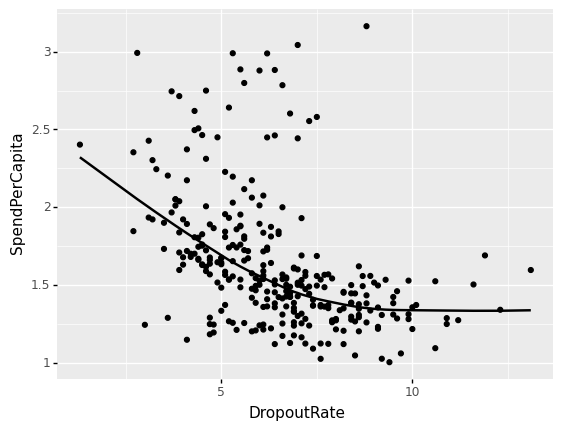

<ggplot: (8787060585569)>

In [65]:
ggplot(keyYears, aes(x = 'DropoutRate', y = 'SpendPerCapita')) + geom_point(stat = 'identity') + stat_smooth()

When examining for a linear relationship between the amount a state spends per capita and their dropout rate a linear pattern is not readily apparent, but there is some sort of correlation.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


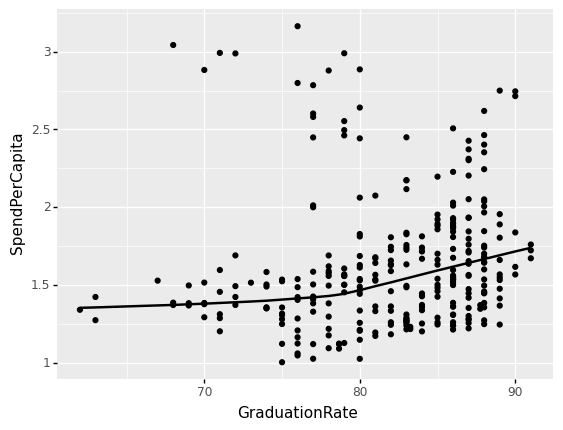

<ggplot: (8787060735329)>

In [66]:
ggplot(keyYears, aes(x = 'GraduationRate', y = 'SpendPerCapita')) + geom_point(stat = 'identity') + stat_smooth()

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


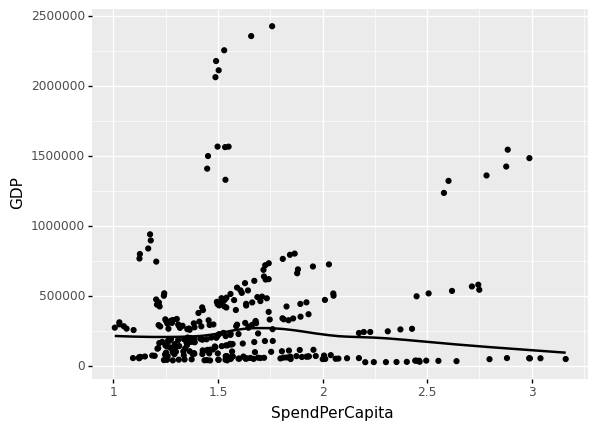

<ggplot: (8787060904656)>

In [67]:
ggplot(keyYears, aes(x = 'SpendPerCapita', y = 'GDP')) + geom_point(stat = 'identity') + stat_smooth()

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


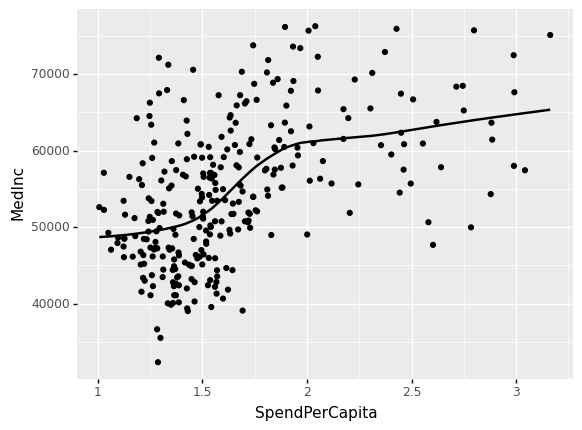

<ggplot: (8787061000593)>

In [68]:
ggplot(keyYears, aes(x = 'SpendPerCapita', y = 'MedInc')) + geom_point(stat = 'identity') + stat_smooth()

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


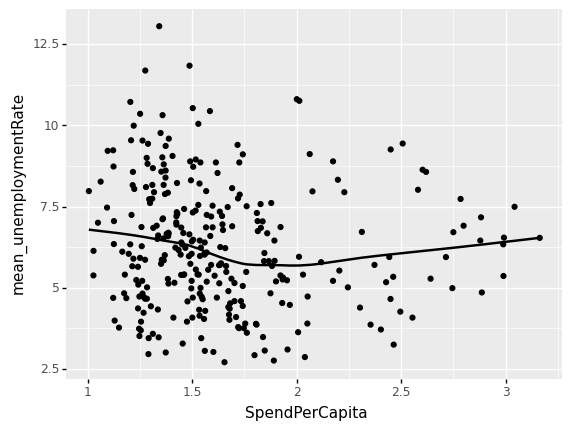

<ggplot: (8787061168978)>

In [69]:
ggplot(keyYears, aes(x = 'SpendPerCapita', y = 'mean_unemploymentRate')) + geom_point(stat = 'identity') + stat_smooth()

We cannot easily see a linear correlation between the spend per capita and the graduation/dropout rates. Neither can we find one for how much the state spends and their GDP. Neither do we see Median Income or Unemployment rates affecting the spending. Which leads us to believe perhaps the spending is set without much consideration for change by lawmakers. We can also hypothesize the amount spent might be largely skewed by other factors such as cost of living that we are not examining in this data set. 

Instead of examining SpendPerCapita lets start examining Median income relationships

In [72]:
stateMeltedMedian = pd.DataFrame(keyYears.groupby('State')['MedInc'].mean().reset_index())
stateMeltedDropout = pd.DataFrame(keyYears.groupby('State')['DropoutRate'].mean().reset_index())

In [73]:
stateMeltedMedian.sort_values('MedInc', ascending = False).head(10)

,State,MedInc
19,Maryland,72264.000000
28,New Hampshire,71355.000000
6,Connecticut,69654.333333
1,Alaska,68669.166667
29,New Jersey,65808.666667
20,Massachusetts,65462.666667
22,Minnesota,65021.833333
10,Hawaii,64569.166667
45,Virginia,64541.166667
5,Colorado,63649.666667


In [74]:
stateMeltedDropout.sort_values('DropoutRate', ascending = True).head(10)

,State,DropoutRate
44,Vermont,3.100000
28,New Hampshire,3.666667
20,Massachusetts,4.000000
18,Maine,4.233333
45,Virginia,4.250000
29,New Jersey,4.300000
10,Hawaii,4.400000
22,Minnesota,4.483333
26,Nebraska,4.600000
6,Connecticut,4.666667


We can see an overlap where 6 of the states within the top 10 states for Median Income have one of the ten lowest dropout rates. (New Hampshire, Connecticut, Hawaii, Minnesota, New Jersey, and Massachusetts)

In [75]:
stateMeltedMedian.sort_values('MedInc', ascending = False).tail(10)

,State,MedInc
32,North Carolina,47406.833333
39,South Carolina,45612.166667
41,Tennessee,45170.833333
0,Alabama,44563.666667
30,New Mexico,44304.666667
17,Louisiana,42782.000000
16,Kentucky,42727.166667
47,West Virginia,42528.833333
3,Arkansas,42220.500000
23,Mississippi,37787.666667


In [76]:
stateMeltedDropout.sort_values('DropoutRate', ascending = False).head(10)

,State,DropoutRate
17,Louisiana,10.800000
27,Nevada,10.183333
2,Arizona,9.166667
30,New Mexico,8.883333
35,Oklahoma,8.700000
23,Mississippi,8.650000
0,Alabama,8.366667
9,Georgia,8.166667
13,Indiana,8.116667
42,Texas,7.866667


We can see an overlap where 4 of the states within the bottom 10 states for Median Income have one of the ten lowest dropout rates. Alabama, New Mexico, Lousiana, Mississippi.

And below we will visualize the linear relationship between the median income and dropout rates.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


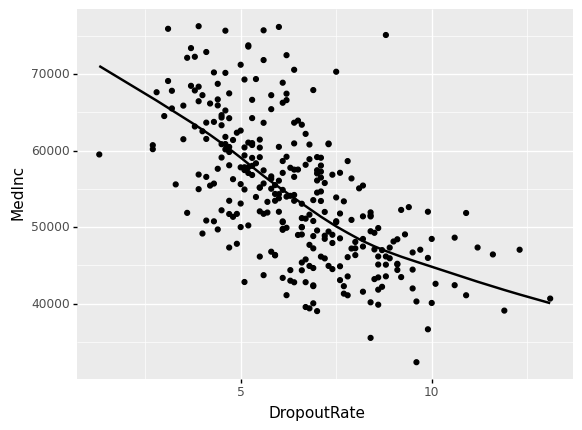

<ggplot: (8787061274453)>

In [77]:
ggplot(keyYears, aes(x = 'DropoutRate', y = 'MedInc')) + geom_point(stat = 'identity') + stat_smooth()

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


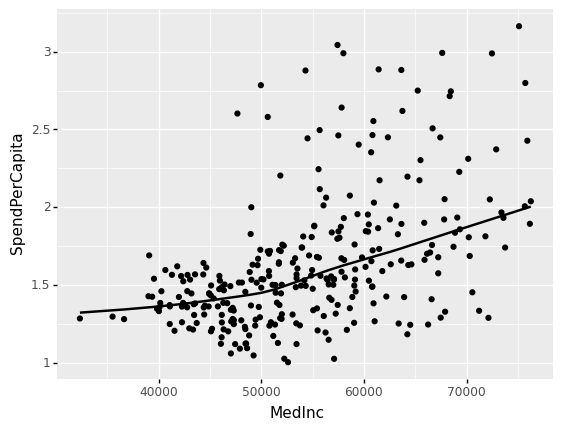

<ggplot: (8787061369697)>

In [78]:
ggplot(keyYears, aes(x = 'MedInc', y = 'SpendPerCapita')) + geom_point(stat = 'identity') + stat_smooth()

Although spend per capita did not immediately show a linear relationship with the dropout/graduate rates. You can see the Median income does influence dropout rates and it also influences how much a state spends per student.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


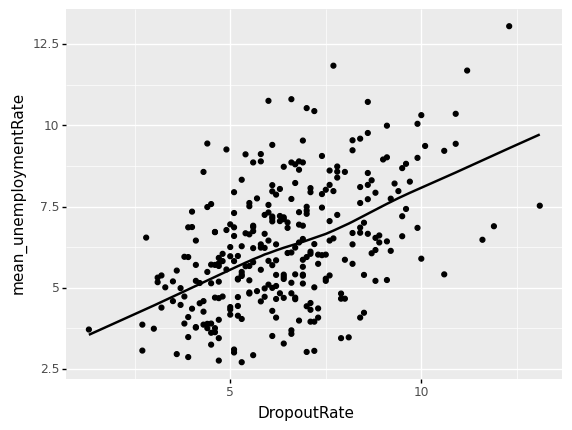

<ggplot: (8787061528929)>

In [79]:
ggplot(keyYears, aes(x= 'DropoutRate', y = 'mean_unemploymentRate',)) + geom_point(stat = 'identity') + stat_smooth()

In [81]:
#Examine based on how much the average tax payer is paying
keyYears['taxPerPop'] = keyYears['TaxAll']/keyYears['Population']

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


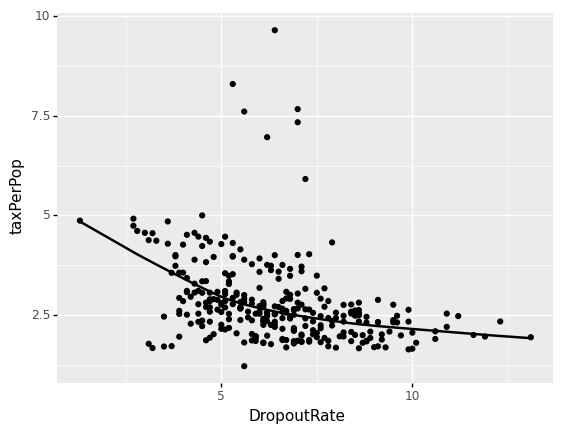

<ggplot: (8787061538741)>

In [83]:
ggplot(keyYears, aes(x= 'DropoutRate', y = 'taxPerPop',)) + geom_point(stat = 'identity') + stat_smooth()

In [84]:
StateMonetary = pd.DataFrame(keyYears.groupby('State')['MedInc','DropoutRate','GraduationRate','SpendPerCapita','GDP'].mean().reset_index())

<ipython-input-84-69a638dde1a8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [86]:
StateMonetarySorted = StateMonetary.sort_values('DropoutRate', ascending = True).reset_index()

In [87]:
keyYears['Year'] = keyYears['Year'].astype('category')

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.


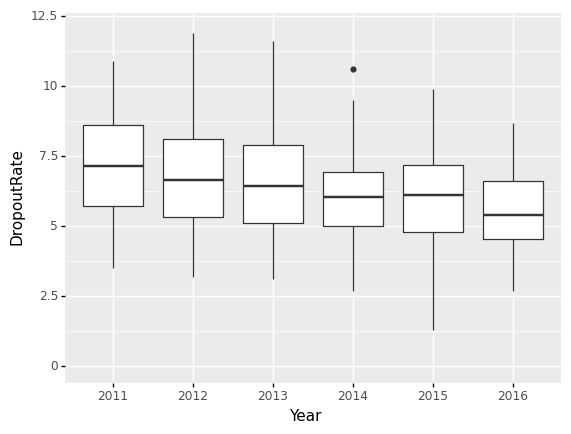

<ggplot: (8787062178235)>

In [89]:
ggplot(keyYears, aes(x = 'Year', y = 'DropoutRate')) + geom_boxplot() + scale_y_continuous(limits = (0,12))

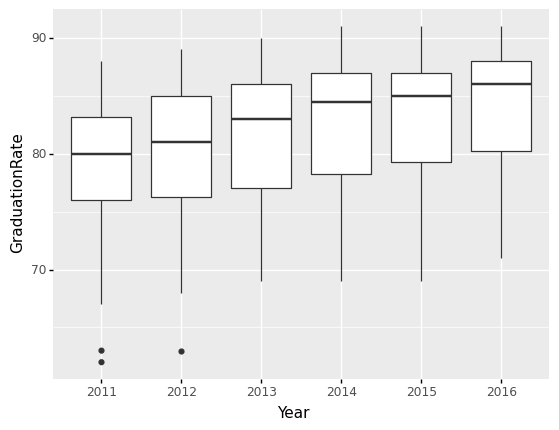

<ggplot: (8787062189373)>

In [90]:
ggplot(keyYears, aes(x = 'Year', y = 'GraduationRate')) + geom_boxplot() + scale_y_continuous() 

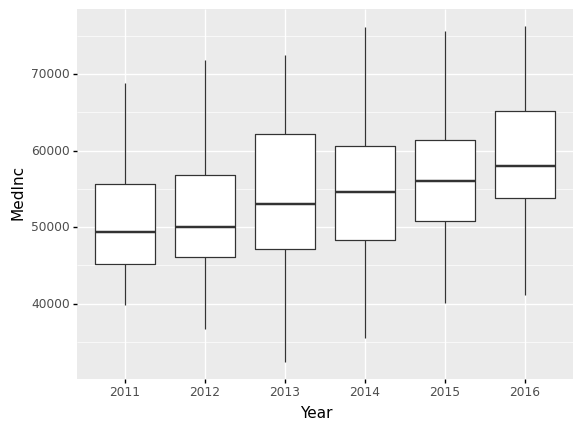

<ggplot: (8787061374175)>

In [91]:
ggplot(keyYears, aes(x = 'Year', y = 'MedInc')) + geom_boxplot() + scale_y_continuous() 

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 19 rows containing non-finite values.


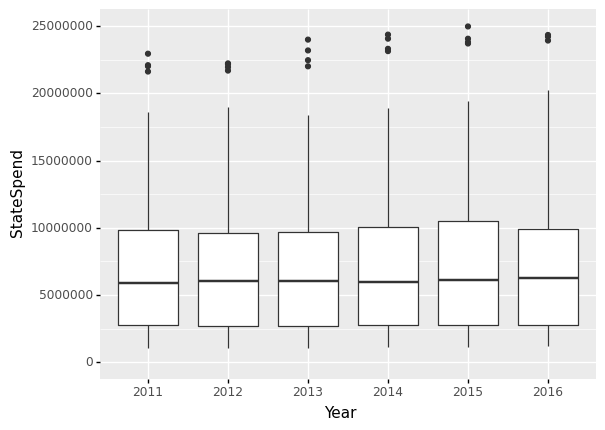

<ggplot: (8787062296887)>

In [93]:
ggplot(keyYears, aes(x = 'Year', y = 'StateSpend')) + geom_boxplot() + scale_y_continuous(limits = (0,25000000)) 

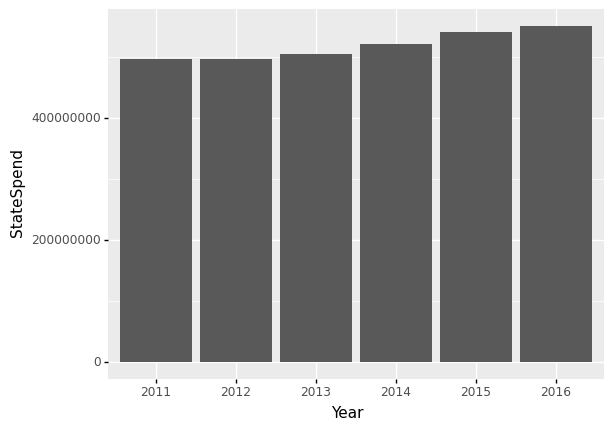

<ggplot: (8787062815600)>

In [94]:
ggplot(keyYears, aes(x ='Year', y = 'StateSpend')) + geom_bar(stat = 'identity')

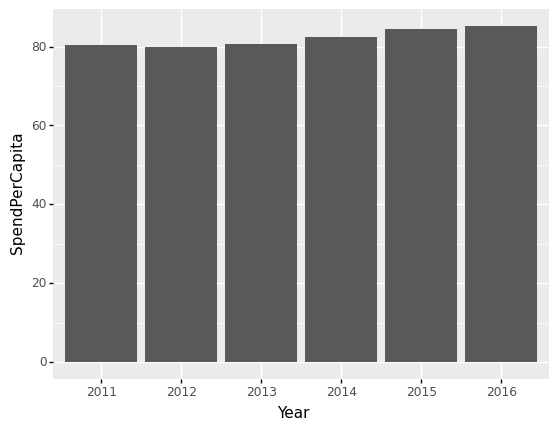

<ggplot: (8787062928637)>

In [95]:
ggplot(keyYears, aes(x ='Year', y = 'SpendPerCapita')) + geom_bar(stat = 'identity')

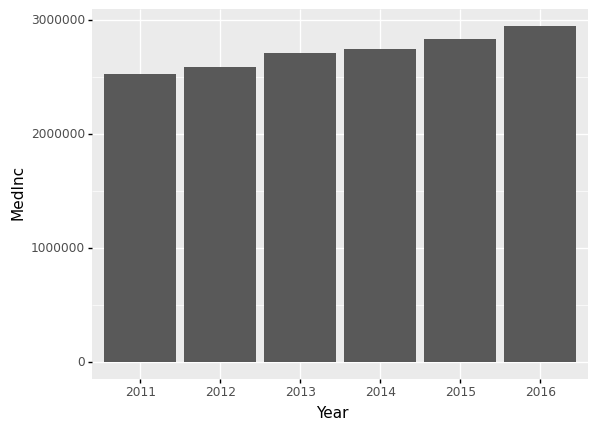

<ggplot: (8787063152478)>

In [98]:
ggplot(keyYears, aes(x ='Year', y = 'MedInc')) + geom_bar(stat = 'identity')

### Observations from yearly boxplots

The median income seems to show a similar inverse relationship to the yearly dropout rate. It also shows a rising pattern in graduation rates. As median income rises, the dropout rate seems to fall.

In [100]:
ts_agg = keyYears.groupby(['Year'])['State', 'GraduationRate', 'DropoutRate', 'MedInc', 'GDP', 'SpendPerCapita'].mean().reset_index().melt(id_vars = ['Year'], var_name = 'cum_type', value_name = 'cum')
print(ts_agg)

    Year        cum_type            cum
0   2011  GraduationRate      79.053333
1   2012  GraduationRate      80.373333
2   2013  GraduationRate      81.513333
3   2014  GraduationRate      82.540000
4   2015  GraduationRate      83.380000
5   2016  GraduationRate      84.140000
6   2011     DropoutRate       7.466000
7   2012     DropoutRate       6.790000
8   2013     DropoutRate       6.596000
9   2014     DropoutRate       6.086000
10  2015     DropoutRate       6.092000
11  2016     DropoutRate       5.598000
12  2011          MedInc   50595.180000
13  2012          MedInc   51742.440000
14  2013          MedInc   54200.720000
15  2014          MedInc   54962.540000
16  2015          MedInc   56750.140000
17  2016          MedInc   58942.940000
18  2011             GDP  306717.740500
19  2012             GDP  318803.357000
20  2013             GDP  329484.706500
21  2014             GDP  343014.924000
22  2015             GDP  355986.020500
23  2016             GDP  365185.340000


<ipython-input-100-bd4edef5665a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Through our 4 year window we can see at a national level that the GDP, median income, and graduation rates are rising each year while the dropout rate does the inverse. Which is a favorable outcome. Again we might want to look into how much of the raises in finances are favorable rises and not just the result of cost of living and inflation.

We do not see the spending changing in the same manner as GDP and Median Income it fluctuates between the same 1.59-1.70 range without any consistency.

In [101]:
keyYears['unemploymentRange'] = keyYears['max_unemploymentRate'] - keyYears['min_unemploymentRate']

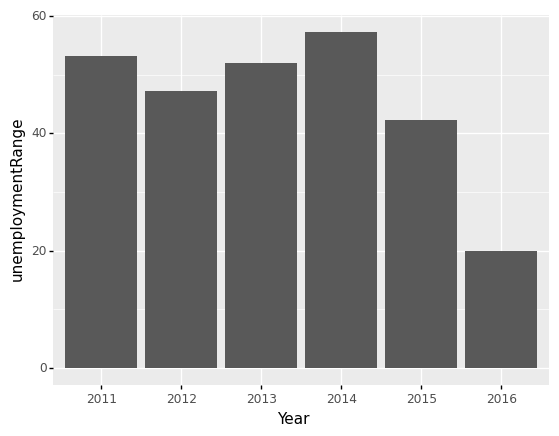

<ggplot: (8787063152246)>

In [102]:
ggplot(keyYears, aes(x ='Year', y = 'unemploymentRange')) + geom_bar(stat = 'identity')

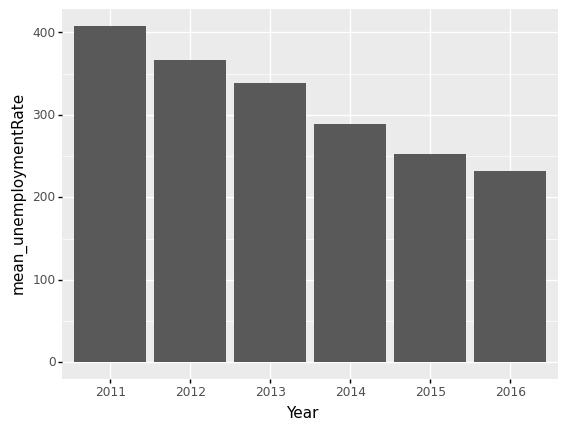

<ggplot: (8787030467018)>

In [103]:
ggplot(keyYears, aes(x ='Year', y = 'mean_unemploymentRate')) + geom_bar(stat = 'identity')

In the small range of time we are looking at we can see the swings in unemployment lessen more and more as the mean unemployment steadily dwindles. 

In [104]:
#Let's remove the averages before we check out all the correlation coefficents.
df = keyYears.iloc[:, 2:13]

<AxesSubplot:>

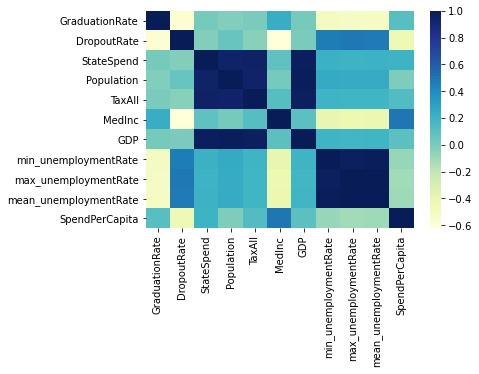

In [105]:
sns.heatmap(df.corr(), cmap="YlGnBu")

In [106]:
df.corr()

,GraduationRate,DropoutRate,StateSpend,Population,TaxAll,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita
GraduationRate,1.000000,-0.582081,0.011374,-0.015149,0.002637,0.235940,0.016408,-0.496129,-0.515142,-0.508122,0.113505
DropoutRate,-0.582081,1.000000,-0.021635,0.067078,-0.038870,-0.623185,0.000936,0.470076,0.488824,0.482827,-0.440919
StateSpend,0.011374,-0.021635,1.000000,0.945412,0.952798,0.089832,0.977640,0.216231,0.205021,0.209045,0.207313
Population,-0.015149,0.067078,0.945412,1.000000,0.938935,0.011717,0.982570,0.253454,0.246203,0.248520,-0.012582
TaxAll,0.002637,-0.038870,0.952798,0.938935,1.000000,0.120875,0.969128,0.200281,0.191395,0.193014,0.131884
MedInc,0.235940,-0.623185,0.089832,0.011717,0.120875,1.000000,0.098688,-0.393280,-0.418348,-0.410503,0.504269
GDP,0.016408,0.000936,0.977640,0.982570,0.969128,0.098688,1.000000,0.196753,0.186735,0.189746,0.097568
min_unemploymentRate,-0.496129,0.470076,0.216231,0.253454,0.200281,-0.393280,0.196753,1.000000,0.974448,0.990084,-0.083436
max_unemploymentRate,-0.515142,0.488824,0.205021,0.246203,0.191395,-0.418348,0.186735,0.974448,1.000000,0.993762,-0.110502
mean_unemploymentRate,-0.508122,0.482827,0.209045,0.248520,0.193014,-0.410503,0.189746,0.990084,0.993762,1.000000,-0.101176


We already experimented and saw some of the correlation between median income and dropout rates. This heat map also shows us the closer relationship between unemployment and dropout rates.

In [108]:
abc = pd.DataFrame(keyYears.groupby(['State', 'Year'])['DropoutRate'].mean().reset_index())
abc.loc[abc['Year'] == 2016].sort_values('DropoutRate').head(10)

,State,Year,DropoutRate
203,North Dakota,2016,2.7
41,Connecticut,2016,3.1
65,Hawaii,2016,3.6
179,New Jersey,2016,3.7
125,Massachusetts,2016,3.8
173,New Hampshire,2016,3.9
275,Virginia,2016,3.9
113,Maine,2016,4.1
71,Idaho,2016,4.1
233,Rhode Island,2016,4.1


In [109]:
abc.loc[abc['Year'] == 2016].sort_values('DropoutRate').tail(10)

,State,Year,DropoutRate
5,Alabama,2016,6.9
83,Indiana,2016,7.0
47,Delaware,2016,7.1
23,Arkansas,2016,7.2
281,Washington,2016,7.5
17,Arizona,2016,7.6
215,Oklahoma,2016,7.9
185,New Mexico,2016,8.2
167,Nevada,2016,8.2
107,Louisiana,2016,8.7


In [111]:
keyYears.groupby('State')['DropoutRate'].mean().sort_values(ascending = False).head(10)

State
Louisiana      10.800000
Nevada         10.183333
Arizona         9.166667
New Mexico      8.883333
Oklahoma        8.700000
Mississippi     8.650000
Alabama         8.366667
Georgia         8.166667
Indiana         8.116667
Texas           7.866667
Name: DropoutRate, dtype: float64

In [112]:
keyYears.groupby('State')['DropoutRate'].mean().sort_values(ascending = False).tail(10)

State
Connecticut      4.666667
Nebraska         4.600000
Minnesota        4.483333
Hawaii           4.400000
New Jersey       4.300000
Virginia         4.250000
Maine            4.233333
Massachusetts    4.000000
New Hampshire    3.666667
Vermont          3.100000
Name: DropoutRate, dtype: float64

In [113]:
temp1 = keyYears[['State', 'Year', 'DropoutRate']]

In [114]:
temp2 = temp1.loc[temp1['Year'].isin([2011, 2016]),:]

In [115]:
temp3 = pd.pivot_table(temp2, index = 'State', columns = 'Year')

In [116]:
temp3.columns = temp3.columns.droplevel()

In [117]:
differenceDropout = temp3[2011] - temp3[2016]

#temp3.head()

In [118]:
differenceDropout = differenceDropout.sort_values()

In [119]:
differenceDropout.tail()

State
Nevada          4.1
Montana         4.4
Louisiana       4.4
Mississippi     4.7
North Dakota    5.2
dtype: float64

In [120]:
differenceDropout.head()

State
Vermont         -0.9
New Hampshire   -0.4
Washington      -0.1
Nebraska        -0.1
Delaware         0.0
dtype: float64

### Summary of our Exploratory Data Analysis 
We notice that Connecticut, Nebraska, Minnesota, Hawaii, New Jersey, Virginia, Maine, Massachusetts, and Vermont have the lowest dropout rates  on average in the past 4 years. 
In 2016 itself we notice the lowest dropout rates come from North Dakota, Connecticut, Hawaii, New Jersey, Massachusetts, New Hampshire, Virginia, Maine, Idaho, and Rhode Island (a 7/10 overlap with the average).


We notice that Louisiana, Nevada, Arizona, New Mexico, Oklahoma, Mississippi, Alabama, Georgia, Indiana, and Texas have the highest dropout rates  on average in the past 4 years.
In 2016 itself we notice the highest dropout rates come from Alabama, Indiana, Delaware, Arkansas, Washington, Arizona, Oklahoma, New Mexico, Nevada, and Louisiana (a 7/10 overlap with the average).

When we compare our earliest dropout rate, 2011, to our latest dropout rates, 2016, we find that Nevada, Montana, Louisiana, Mississippi, and North Dakota lowered their rates the most dramatically. In reverse the states that increased their rates of dropouts the most were Vermont, New Hampshire, Washington, Nebraska, and Delaware.

We also notice that while the GDP and Median Income have a linear relationship to the dropout rates they do not have a linear relationship to State Spending. This leads us to wonder. How stagnate are the rates of spending in each state if they're not affected by GDP/Median Income and should we change that? We can also start to discuss other studies that show students with parents who have higher education and/or median income have higher rates of academic succes.

# 4) Preprocess and Train Data

In [121]:
keyYears.columns

Index(['State', 'Year', 'GraduationRate', 'DropoutRate', 'StateSpend',
       'Population', 'TaxAll', 'MedInc', 'GDP', 'min_unemploymentRate',
       'max_unemploymentRate', 'mean_unemploymentRate', 'SpendPerCapita',
       'US_Avg_Grad', 'US_Avg_Drop', 'US_Avg_Tax', 'US_Avg_Unemployment',
       'US_Avg_SPC', 'AboveAvgRetention', 'taxPerPop', 'unemploymentRange'],
      dtype='object')

I will be using 0/1 above average retention as my y feature. For x we will use year, graduates, dropout, population, tax, median income, gdp, mean unemployment, spend per capita

Since spend per capita seems to have a larger correlation and is scaled for accuracy we will drop state spend itself.

In [126]:
feature_list = ['Year', 'GraduationRate', 'Population',
       'TaxAll', 'MedInc', 'GDP', 'mean_unemploymentRate', 'SpendPerCapita']

In [127]:
y = keyYears['AboveAvgRetention']
X = keyYears[feature_list]

In [129]:
from sklearn.model_selection import train_test_split

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [131]:
# build scaler based on training data and use to scale testing and training features
# StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [132]:
X_train.shape

(225, 8)

# NOTE TO SELF: Look at the confusion matrix
## Wednesday November 24
Build a logisitic regression model.
It will show me the slope. 
Look at the summary of the model (fit).

When we are trying to explain a simpler model like Logistic Regression is nice. If we want more power/accuracy we try Random Forest and XGBoost. Generally if the model is stronger/accurate it's harder to explain. If it's easier to explain it's generally a weaker model.

you can add additional variables like “prev years state spend “ or “change or difference in state spend compared to previous year “ as additional variables.

# 5) Build Predictive Models

## Random Forest Model

In [133]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [134]:
tuned_parameters = {'n_estimators':range(20,91,10), 'max_depth':range(2,7), 'min_samples_split':range(100,1000,200)}
model = RandomForestClassifier(random_state=42)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')

%%time

Best parameters set found on development set:
{'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 30} 



UsageError: Line magic function `%%time` not found.


In [136]:
#Build random forest model with best params
rf = RandomForestClassifier(random_state=42)

#Train the model
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)


#Find accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.827
Random Forest: f1-score=0.827


In [137]:
model.score(X_test, y_test)

0.8266666666666667

In [138]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SpendPerCapita       Importance: 0.25
Variable: MedInc               Importance: 0.18
Variable: GraduationRate       Importance: 0.13
Variable: Population           Importance: 0.12
Variable: TaxAll               Importance: 0.11
Variable: GDP                  Importance: 0.09
Variable: mean_unemploymentRate Importance: 0.08
Variable: Year                 Importance: 0.04


In [139]:
#Build random forest model with scaled data
rf = RandomForestClassifier(random_state=42)

#Train the model
model = rf.fit(X_train_scaled, y_train)
y_pred_scaled = model.predict(X_test_scaled)
y_pred_prob_scaled = model.predict_proba(X_test_scaled)
lr_probs_scaled = y_pred_prob_scaled[:,1]
ac_scaled = accuracy_score(y_test, y_pred)


#Find accuracy
f1_scaled = f1_score(y_test, y_pred, average='weighted')
cm_scaled = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac_scaled))

print('Random Forest: f1-score=%.3f' % (f1_scaled))

Random Forest: Accuracy=0.827
Random Forest: f1-score=0.827


In [140]:
# Same results scaled or not scaled

## KNN Model

In [141]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [142]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7766666666666666
Best Parameters: {'n_neighbors': 1}


In [147]:
#Build KNN model with best params
knn = KNeighborsClassifier(n_neighbors = 1)

#Train the model
knnmodel = knn.fit(X_train, y_train)
y_pred_knn = knnmodel.predict(X_test)
y_pred_prob_knn = knnmodel.predict_proba(X_test)
lr_probs_knn = y_pred_prob_knn[:,1]
ac_knn = accuracy_score(y_test, y_pred_knn)


#Find accuracy
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
cm_knn = confusion_matrix(y_test, y_pred_knn)

print('K Nearest Neighbors: Accuracy=%.3f' % (ac_knn))

print('K Nearest Neighbors: f1-score=%.3f' % (f1_knn))

K Nearest Neighbors: Accuracy=0.720
K Nearest Neighbors: f1-score=0.719
